In [161]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## *Importing and Distributing Data*

In [162]:
musics = pd.read_csv('TASK2_dataset.csv')
print(musics.head())


key1 = musics.keyword_1.unique()
key2 = musics.keyword_2.unique()
key3 = musics.keyword_3.unique()
genre = musics.genre.unique()
count = len(musics.genre)

   song_id keyword_1  keyword_2  keyword_3      genre
0       74    guitar      happy  distorted       rock
1      103     brass  energetic    melodic  classical
2      201     banjo      happy   acoustic    country
3      194     synth  energetic      heavy    hip-hop
4      184     synth  energetic       slow    hip-hop


# *Vectorisation*

## BOW

In [163]:
key_BOW_1 = np.zeros((count,len(key1)))
key_BOW_2 = np.zeros((count,len(key2)))
key_BOW_3 = np.zeros((count,len(key3)))


for i in range(count):
    for j in range(len(key1)):
        if key1[j] in musics.keyword_1[i]:
            key_BOW_1[i][j] += 1
    
    for j in range(len(key2)):
        if key2[j] in musics.keyword_2[i]:
            key_BOW_2[i][j] += 1
    
    for j in range(len(key3)):
        if key3[j] in musics.keyword_3[i]:
            key_BOW_3[i][j] += 1
            

## TF-IDF

In [164]:
tf_1 = np.copy(key_BOW_1)/3
tf_2 = np.copy(key_BOW_2)/3
tf_3 = np.copy(key_BOW_3)/3

idf_1 = np.zeros(len(key1))
idf_2 = np.zeros(len(key2))
idf_3 = np.zeros(len(key3))

for i in range(len(key1)):
    idf_1[i] = np.log((count+1)/sum(tf_1[:,i]+1))
for i in range(len(key2)):
    idf_2[i] = np.log((count+1)/sum(tf_2[:,i]+1))
for i in range(len(key3)):
    idf_3[i] = np.log((count+1)/sum(tf_3[:,i]+1))
    
tfidf_1 = tf_1 * idf_1
tfidf_2 = tf_2 * idf_2
tfidf_3 = tf_3 * idf_3

# *PCA*

In [165]:
def pca(set):
    temp = set - np.mean(set)
    temp = temp / np.std(temp)
    
    temp = np.cov (temp.T)
    
    eigenval , eigenvect = np.linalg.eig(temp)
    
    indepcas = np.argsort(eigenval)[::-1]

    eigenvect = eigenvect[:,indepcas[0:2]]
    
    temp = set @ eigenvect
    
    return temp
    
    

pca_1_tf = pca(tfidf_1)
pca_2_tf = pca(tfidf_2)
pca_3_tf = pca(tfidf_3)

pcas_tf =  np.cbrt(pca_1_tf**5 + pca_2_tf**5 + pca_3_tf**5)



pca_1_bow = pca(key_BOW_1)
pca_2_bow = pca(key_BOW_2)
pca_3_bow = pca(key_BOW_3)

pcas_bow = np.cbrt(pca_1_bow**5 + pca_2_bow**5 + pca_3_bow**5)
    

# *K-Means*

In [166]:

cents = 10
def kmeans(pcas):

    np.random.seed(100)  
    centroids = pcas[np.random.choice(range(len(pcas)),cents , replace=False)]

    for i in range(100):
        distances = np.linalg.norm(pcas[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)

        new_centroids = np.array([pcas[labels == j].mean(axis=0) for j in range(cents)])

        centroids = new_centroids
    return centroids,labels
    

centroids_tf, labels_tf = kmeans(pcas_tf)
centroids_bow, labels_bow = kmeans(pcas_bow)
        

# Plot of the PCA distribution

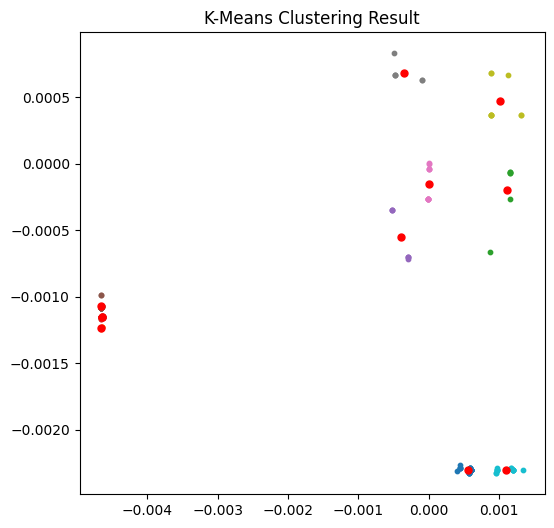

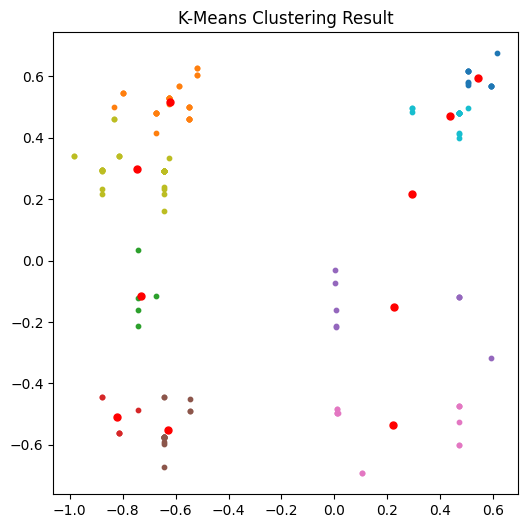

In [167]:
def plot(pcas,centroids, labels,cents):

    plt.figure(figsize=(6,6))
    for i in range(cents):
        plt.scatter(pcas[labels == i][:, 0], pcas[labels == i][:, 1],s=10 )
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='.', color='red', s=100, label="Centroids")
    plt.title("K-Means Clustering Result")
    plt.show()

plot(pcas_tf , centroids_tf , labels_tf , cents)
plot(pcas_bow , centroids_bow , labels_bow , cents)

# Distribution table for clusters and genre

In [168]:
def distribution_table(labels):

    musics["Cluster"] = labels  


    genre_distribution = musics.groupby(["Cluster", "genre"]).size().unstack().fillna(0)


    genre_distribution = genre_distribution.div(genre_distribution.sum(axis=1), axis=0) * 100


    print(genre_distribution)
    
distribution_table(labels_tf)
distribution_table(labels_bow)

genre     classical    country    hip-hop        pop       rock
Cluster                                                        
0          0.000000   0.000000  74.074074  25.925926   0.000000
1          0.000000  40.000000   0.000000  10.000000  50.000000
2         66.666667  16.666667   0.000000  16.666667   0.000000
3          0.000000  33.333333   0.000000  18.181818  48.484848
4         57.142857  14.285714   0.000000  28.571429   0.000000
5          0.000000  36.363636   0.000000  22.727273  40.909091
6         45.454545  27.272727   0.000000  27.272727   0.000000
7        100.000000   0.000000   0.000000   0.000000   0.000000
8         88.888889  11.111111   0.000000   0.000000   0.000000
9          0.000000   0.000000  62.500000  37.500000   0.000000
genre     classical    country    hip-hop        pop       rock
Cluster                                                        
0         16.666667   0.000000  50.000000  33.333333   0.000000
1          6.250000  18.750000  25.00000

# Checking for Silhouette Score

In [169]:
def silhouette_score(pcas,labels):
    n = pcas.shape[0]
    unique_clusters = np.unique(labels)  

    a_values = np.zeros(n)  

    for i in range(n):
        own_cluster = labels[i]
        own_cluster_points = pcas[labels == own_cluster] 
    
        if len(own_cluster_points) > 1:
           distances = [np.linalg.norm(pcas[i] - p) for p in own_cluster_points if not np.array_equal(pcas[i], p)]
           a_values[i] = np.mean(distances) 
        else:
            a_values[i] = 0 

    b_values = np.zeros(n)

    for i in range(n):
        own_cluster = labels[i]
        min_cluster_distance = float('inf')

        for cluster in unique_clusters:
            if cluster == own_cluster:
                continue  

            other_cluster_points = pcas[labels == cluster]
            mean_distance = np.mean([np.linalg.norm(pcas[i] - p) for p in other_cluster_points])
            min_cluster_distance = min(min_cluster_distance, float(mean_distance))  

        b_values[i] = min_cluster_distance


    silhouette_scores = np.zeros(n)

    for i in range(n):
        silhouette_scores[i] = (b_values[i] - a_values[i]) / max(a_values[i], b_values[i])

    silhouette_score = np.mean(silhouette_scores)

    print("Silhouette Score:", silhouette_score)
    

silhouette_score(pcas_tf,labels_tf)
silhouette_score(pcas_bow,labels_bow)

Silhouette Score: 0.7632515324106137
Silhouette Score: 0.5039214943156746


In [170]:
import numpy as np

def predict_genre(keyword1, keyword2, keyword3, musics, genre):
    key_rep = np.zeros((3,len(genre)))
    for j in range(len(genre)):
        for k in range(len(musics.genre)):
            if genre[j] == musics.genre[k]:
                if keyword1 == musics.keyword_1[k]:
                    key_rep[0][j] += 1
                if keyword2 == musics.keyword_2[k]:
                    key_rep[1][j] += 1
                if keyword3 == musics.keyword_3[k]:
                    key_rep[2][j] += 1
    print (key_rep)
    key_mult = (key_rep[0]+1)**3 * (key_rep[1]+1)**3 * (key_rep[2]+1)**3
    print(key_mult)
    return genre[np.argsort(key_mult)[::-1]]
    
            

# Example usage:
k1, k2, k3 = "synth", "sad", "danceable"
print(predict_genre(k1, k2, k3, musics, genre))

[[ 0.  0.  0. 30. 13.]
 [ 6.  4.  5.  6.  0.]
 [ 0.  0.  0.  0.  5.]]
[3.4300000e+02 1.2500000e+02 2.1600000e+02 1.0218313e+07 5.9270400e+05]
['hip-hop' 'pop' 'rock' 'country' 'classical']
